In [4]:
%%capture
!pip3 install nltk
!pip3 install nltk
!pip3 install plotly
!pip3 install gensim
!pip3 install python-Levenshtein

In [5]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import pandas as pd
import html
from wordcloud import WordCloud
import nltk
import re
from IPython.display import Markdown, display
from gensim import utils
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import numpy
from random import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from nltk.corpus import stopwords

csv_file = open('sms_collection.csv', 'r')
lines = csv_file.readlines()

VALID_LABELS = ["spam", "ham"]

dataframe_cols = ["IsSpam", "MessageText"]
sms_data = pd.DataFrame(columns = dataframe_cols)

is_header = True
for line in lines:
    # skip the first line
    if is_header:
        is_header = False
        continue

    parts = line.split(";")
    label = parts[0]
    
    if label not in VALID_LABELS:
        exit("Unknown label supplied for SMS data")

    sms_text = html.unescape(";".join(parts[1:]))
    sms_text.rstrip()
    sms_text.lstrip()

    is_spam = int(label == "spam")

    row = pd.DataFrame([[is_spam, sms_text]], columns = ["IsSpam", "MessageText"])
    sms_data = sms_data.append(row)

In [6]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    sms_data,
    sms_data['IsSpam'],
    test_size = 0.2
)

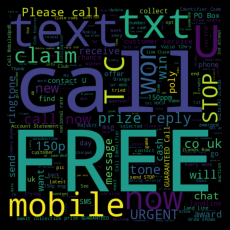

In [7]:
spam_contents = " ".join(list(sms_data.loc[sms_data['IsSpam'] == 1]['MessageText']))
spam_wordcloud = WordCloud(width = 512, height = 512).generate(spam_contents)
plt.figure(figsize = (3, 3), facecolor = "k")
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

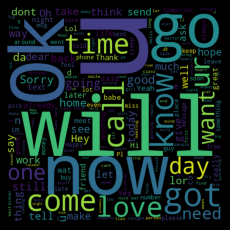

In [8]:
ham_contents = " ".join(list(sms_data.loc[sms_data['IsSpam'] == 0]['MessageText']))
ham_wordcloud = WordCloud(width = 512, height = 512).generate(ham_contents)
plt.figure(figsize = (3, 3), facecolor = "k")
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [9]:
total_observations = len(sms_data.index)
print("Dataset Size: {}".format(total_observations))
print(sms_data['IsSpam'].value_counts())
print(sms_data['IsSpam'].value_counts() / len(sms_data.index) * 100.0)

Dataset Size: 5574
0    4827
1     747
Name: IsSpam, dtype: int64
0    86.598493
1    13.401507
Name: IsSpam, dtype: float64


In [30]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('wordnet')

def pre_process(message):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    porter_stemmer = PorterStemmer()

    tokens = nltk.word_tokenize(message)
    
    # lowercase everything
    tokens = [word.lower() for word in tokens]
    
    # lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # stemming
    tokens = [porter_stemmer.stem(word) for word in tokens]
    
    return tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/siddharthchaubal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
X_train_tagged = X_train.apply(lambda sms: TaggedDocument(words=pre_process(sms['MessageText']), tags=[sms.IsSpam]), axis=1)
X_test_tagged = X_test.apply(lambda sms: TaggedDocument(words=pre_process(sms['MessageText']), tags=[sms.IsSpam]), axis=1)

In [32]:
X_train_tagged[0]

0                    ([much, r, ü, will, pay, ?], [0])
0               ([da, ., happi, sit, togeth, na], [0])
0                 ([also, bring, galileo, dobbi], [0])
0    ([madam, ,, regret, disturbance.might, receiv,...
0    ([special, select, receiv, 2000, pound, award,...
                           ...                        
0    ([still, havent, collect, dough, pl, let, know...
0    ([ron, say, fri, leh, ., n, said, ding, tai, f...
0    ([hey, !, congrat, 2u2, ., id, luv, 2, ive, 2,...
0            ([kalli, wont, bat, 2nd, inning, .], [0])
0    ([know, old, dom, told, yesterday, ?, name, ro...
Length: 4459, dtype: object

In [34]:
# build a doc2vec model with the tagged values from the training set
doc2vec_model = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0)
doc2vec_model.build_vocab([x for x in X_train_tagged.values])

epoch_count = 50
for epoch in range(50):
    doc2vec_model.train(sklearn.utils.shuffle([x for x in X_train_tagged.values]), total_examples=len(X_train_tagged.values), epochs=1)
    doc2vec_model.alpha -= 0.002
    doc2vec_model.min_aplha = doc2vec_model.alpha

In [39]:
def vectorize(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps = 20)) for doc in sents])

    return targets, regressors

def show_metrics(description, Y_expected, Y_predicted):
    display(Markdown(f"**{description}**"))
    print('Accuracy %s' % accuracy_score(Y_expected, Y_predicted))
    print('Precision %s' % precision_score(Y_expected, Y_predicted))
    print('Recall %s' % recall_score(Y_expected, Y_predicted))
    print('F1 score: {}'.format(f1_score(Y_expected, Y_predicted, average='weighted')))

In [40]:
Y_train_final, X_train_final = vectorize(doc2vec_model, X_train_tagged)
Y_test_final, X_test_final = vectorize(doc2vec_model, X_test_tagged)

In [41]:
# train our logistic regression model and fit the training data
logistic_regression = LogisticRegression(max_iter = 100000)
logistic_regression.fit(X_train_final, Y_train_final)

Y_predicted_log_reg = logistic_regression.predict(X_test_final)
show_metrics('Logistic Regression Performance Metrics:', Y_test_final, Y_predicted_log_reg)

**Logistic Regression Performance Metrics:**

Accuracy 0.8932735426008969
Precision 0.7721518987341772
Recall 0.3765432098765432
F1 score: 0.8771221567157782


In [42]:
# train our logistic regression model and fit the training data
svm = SVC(max_iter = 100000)
svm.fit(X_train_final, Y_train_final)

Y_predicted_log_reg = svm.predict(X_test_final)
show_metrics('SVM Performance Metrics:', Y_test_final, Y_predicted_log_reg)

**SVM Performance Metrics:**

Accuracy 0.9013452914798207
Precision 0.7888888888888889
Recall 0.4382716049382716
F1 score: 0.8890472973366869
